In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust to a smaller size to speed up training
    transforms.Grayscale(3),      # Convert to three channel (like RGB)
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize using grayscale mean and std
])

# Load MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, transform=transform)


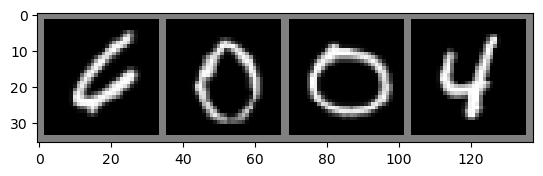

In [19]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img.mean(dim=0)  # Convert to single channel for display
    plt.imshow(img, cmap='gray')
    plt.show()

# Get some random training images
dataiter = iter(DataLoader(mnist_trainset, batch_size=4, shuffle=True))
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


In [20]:
# Splitting the dataset
train_size = int(0.9 * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
mnist_train, mnist_val = random_split(mnist_trainset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=32, shuffle=False)


In [24]:
import torch.nn as nn
from torchvision.models import resnet18

class SimResNet(nn.Module):
    def __init__(self):
        super(SimResNet, self).__init__()
        original_resnet = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(original_resnet.children())[:-4])  # Take only the first few layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(128, 10)  # Adapt to MNIST classes

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = SimResNet()
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))


SimResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Epoch 1 training loss: 0.11288151454737176
Epoch 1 validation loss: 0.043498719042040744
Epoch 2 training loss: 0.0385273317214346
Epoch 2 validation loss: 0.038110351268613236
Epoch 3 training loss: 0.02915050691305119
Epoch 3 validation loss: 0.022234432635431924
Epoch 4 training loss: 0.02552569357305048
Epoch 4 validation loss: 0.025106969352681845
Epoch 5 training loss: 0.02068016400421821
Epoch 5 validation loss: 0.025228211129828235
Epoch 6 training loss: 0.017815729613434413
Epoch 6 validation loss: 0.040072895870639995
Epoch 7 training loss: 0.015114287819867633
Epoch 7 validation loss: 0.02512395371872736
Epoch 8 training loss: 0.013799222121168124
Epoch 8 validation loss: 0.029785952943421626
Epoch 9 training loss: 0.012300760601150424
Epoch 9 validation loss: 0.017736209307345912
Epoch 10 training loss: 0.010804396824711316
Epoch 10 validation loss: 0.0287218618635226
Epoch 11 training loss: 0.009795590762237592
Epoch 11 validation loss: 0.03860591350981617
Epoch 12 trainin

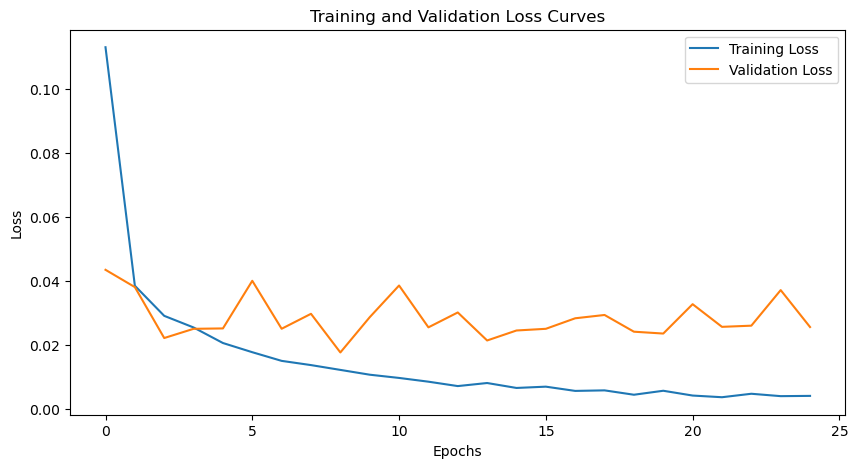

In [25]:
import torch.optim as optim
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(25):  
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1} training loss: {running_loss / len(train_loader)}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch + 1} validation loss: {val_loss / len(val_loader)}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total}%')

test_loader = DataLoader(mnist_testset, batch_size=32, shuffle=False)
predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

print(predictions[:10])  # Print the first 10 predictions


Accuracy of the network on the validation images: 99.36666666666666%
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
